# **Import libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
import seaborn as sns

# **Loading the dataset**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CPCB.csv')

# **Exploring the data**

In [ ]:
data.head()

,Datetime,NO2,O3,CO,SO2,Temp,RH,PM2.5,PM10
0,01-07-2022 00:00,2.175523,1.171429,233.043584,4.965646,23.336625,72.361834,11.883808,19.943981
1,01-07-2022 01:00,2.175523,1.171429,233.043584,4.965646,23.336625,72.361834,11.883808,19.943981
2,01-07-2022 02:00,2.175523,1.171429,233.043584,4.965646,23.336625,72.361834,11.883808,19.943981
3,01-07-2022 03:00,2.175523,1.171429,233.043584,4.965646,23.336625,72.361834,11.883808,19.943981
4,01-07-2022 04:00,2.175523,1.171429,233.043584,4.965646,23.336625,72.361834,11.883808,19.943981


In [ ]:
data.describe()

,NO2,O3,CO,SO2,Temp,RH,PM2.5,PM10
count,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000
mean,2.176745,1.173476,235.143765,4.978822,23.293260,72.685802,12.092634,20.034472
std,0.585049,2.622279,121.485137,1.170514,2.782650,15.706897,8.870804,15.536308
min,1.765969,0.186224,0.000000,2.920644,17.892000,13.042500,0.279585,0.319974
25%,2.132156,0.447881,165.583675,3.943222,21.000000,68.760000,5.358683,10.096638
50%,2.175523,0.684918,233.043584,4.965646,23.336625,72.361834,11.883808,19.943981
75%,2.241776,1.171429,250.962758,6.037213,25.412000,84.490000,13.989915,21.900803
max,25.885676,34.519615,1332.431136,9.834521,28.319500,99.132500,66.804468,392.741170


In [ ]:
data.shape

(8881, 9)

In [ ]:
data.dtypes

,0
Datetime,object
NO2,float64
O3,float64
CO,float64
SO2,float64
Temp,float64
RH,float64
PM2.5,float64
PM10,float64


In [ ]:
data.columns

Index(['Datetime', 'NO2', 'O3', 'CO', 'SO2', 'Temp', 'RH', 'PM2.5', 'PM10'], dtype='object')

# **Pre-processing the data**

In [ ]:
data.isnull().sum()
# No missing values

,0
Datetime,0
NO2,0
O3,0
CO,0
SO2,0
Temp,0
RH,0
PM2.5,0
PM10,0


In [ ]:
data_numerical = data.select_dtypes(include=np.number)

In [ ]:
data_selected = data_numerical[['CO', 'SO2', 'PM10', 'PM2.5']]

minmax = MinMaxScaler()
data = minmax.fit_transform(data_selected)

In [ ]:
import pandas as pd

window_size = 3

denoised_df = data.copy()
columns_to_smooth = [col for col in data.columns if col != 'Datetime']

denoised_df[columns_to_smooth] = data[columns_to_smooth].rolling(window=window_size, center=True).mean()

denoised_df.to_csv('denoised_data_rolling.csv', index=False)
print("Denoised data saved to 'denoised_data_rolling.csv'.")


Denoised data saved to 'denoised_data_rolling.csv'.


In [ ]:
numerical_data = data[['NO2', 'O3', 'CO', 'SO2', 'Temp', 'RH', 'PM2.5', 'PM10']]

Q1 = np.percentile(numerical_data, 25, axis=0)
Q3 = np.percentile(numerical_data, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_df = pd.DataFrame([lower_bound], columns=numerical_data.columns)
upper_df = pd.DataFrame([upper_bound], columns=numerical_data.columns)

# Winsorize: clip values outside bounds
data_winsorized = numerical_data.clip(lower=lower_df, upper=upper_df, axis=1)

data[['NO2', 'O3', 'CO', 'SO2', 'Temp', 'RH', 'PM2.5', 'PM10']] = data_winsorized

Number of outliers detected per column:
PM2.5     625
PM10      775
NO2      1714
O3        263
SO2         3
CO        900
dtype: int64

Shape before cleaning: (8881, 9)
Shape after cleaning: (5856, 9)


# **Exploratory Data Analysis**

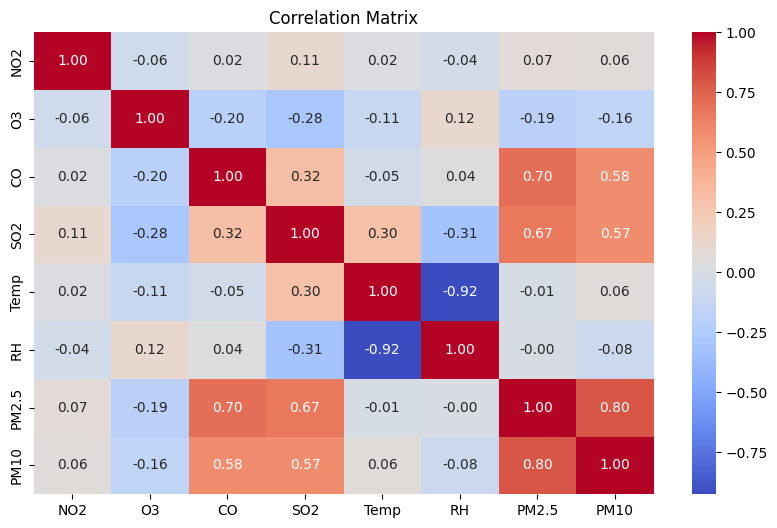

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_numerical.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

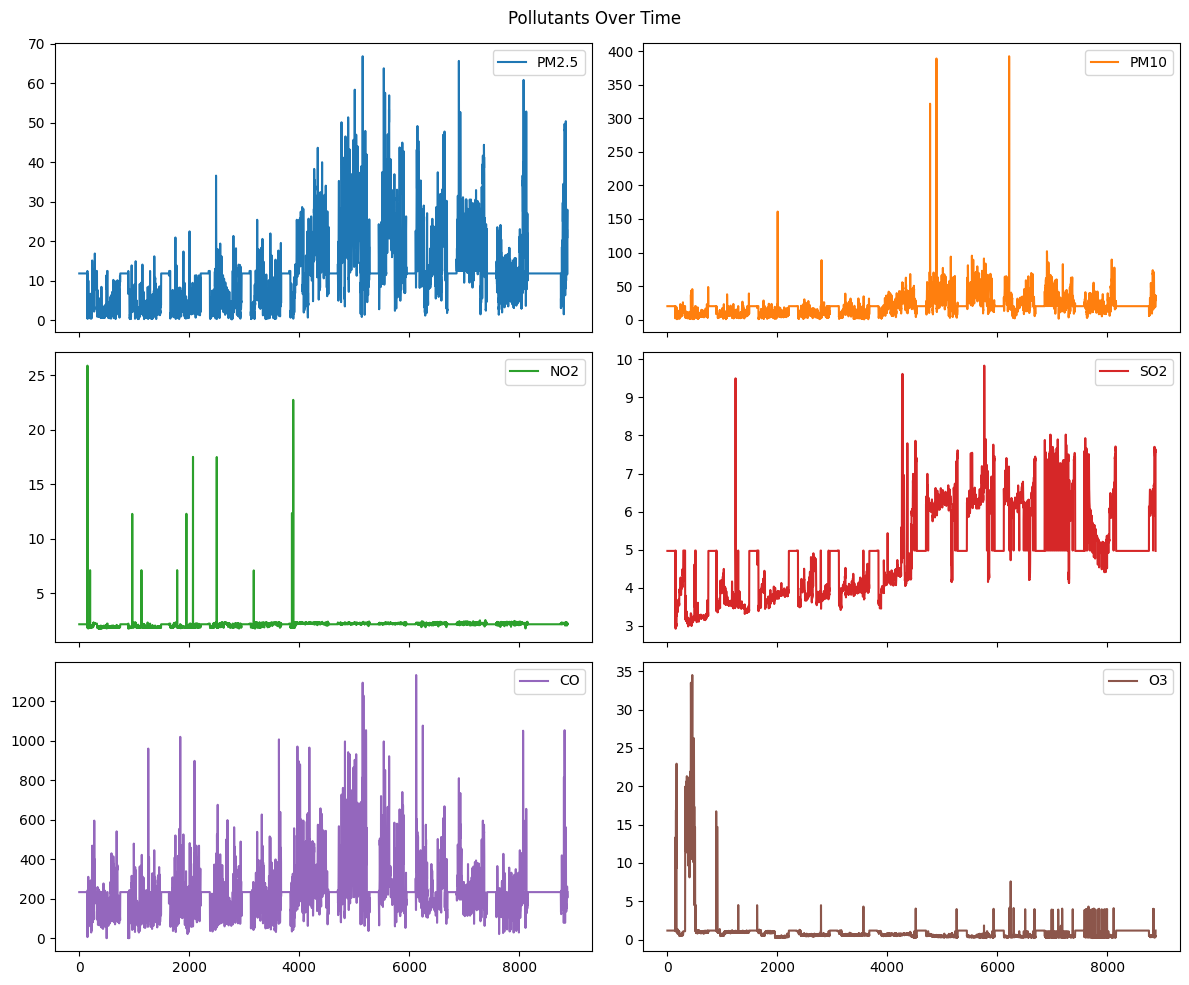

In [ ]:
data[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']].plot(subplots=True, figsize=(12, 10), layout=(3, 2), title="Pollutants Over Time")
plt.tight_layout()
plt.show()


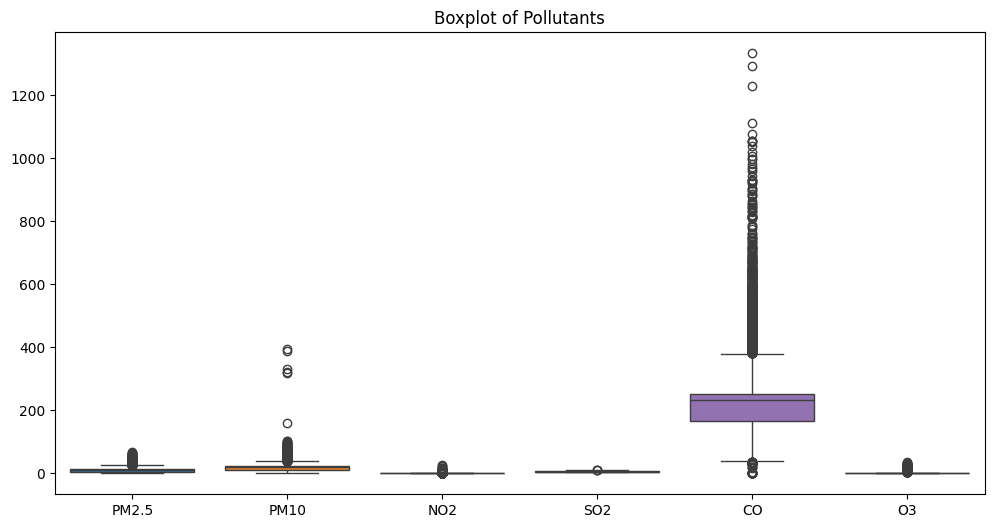

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']])
plt.title("Boxplot of Pollutants")
plt.show()

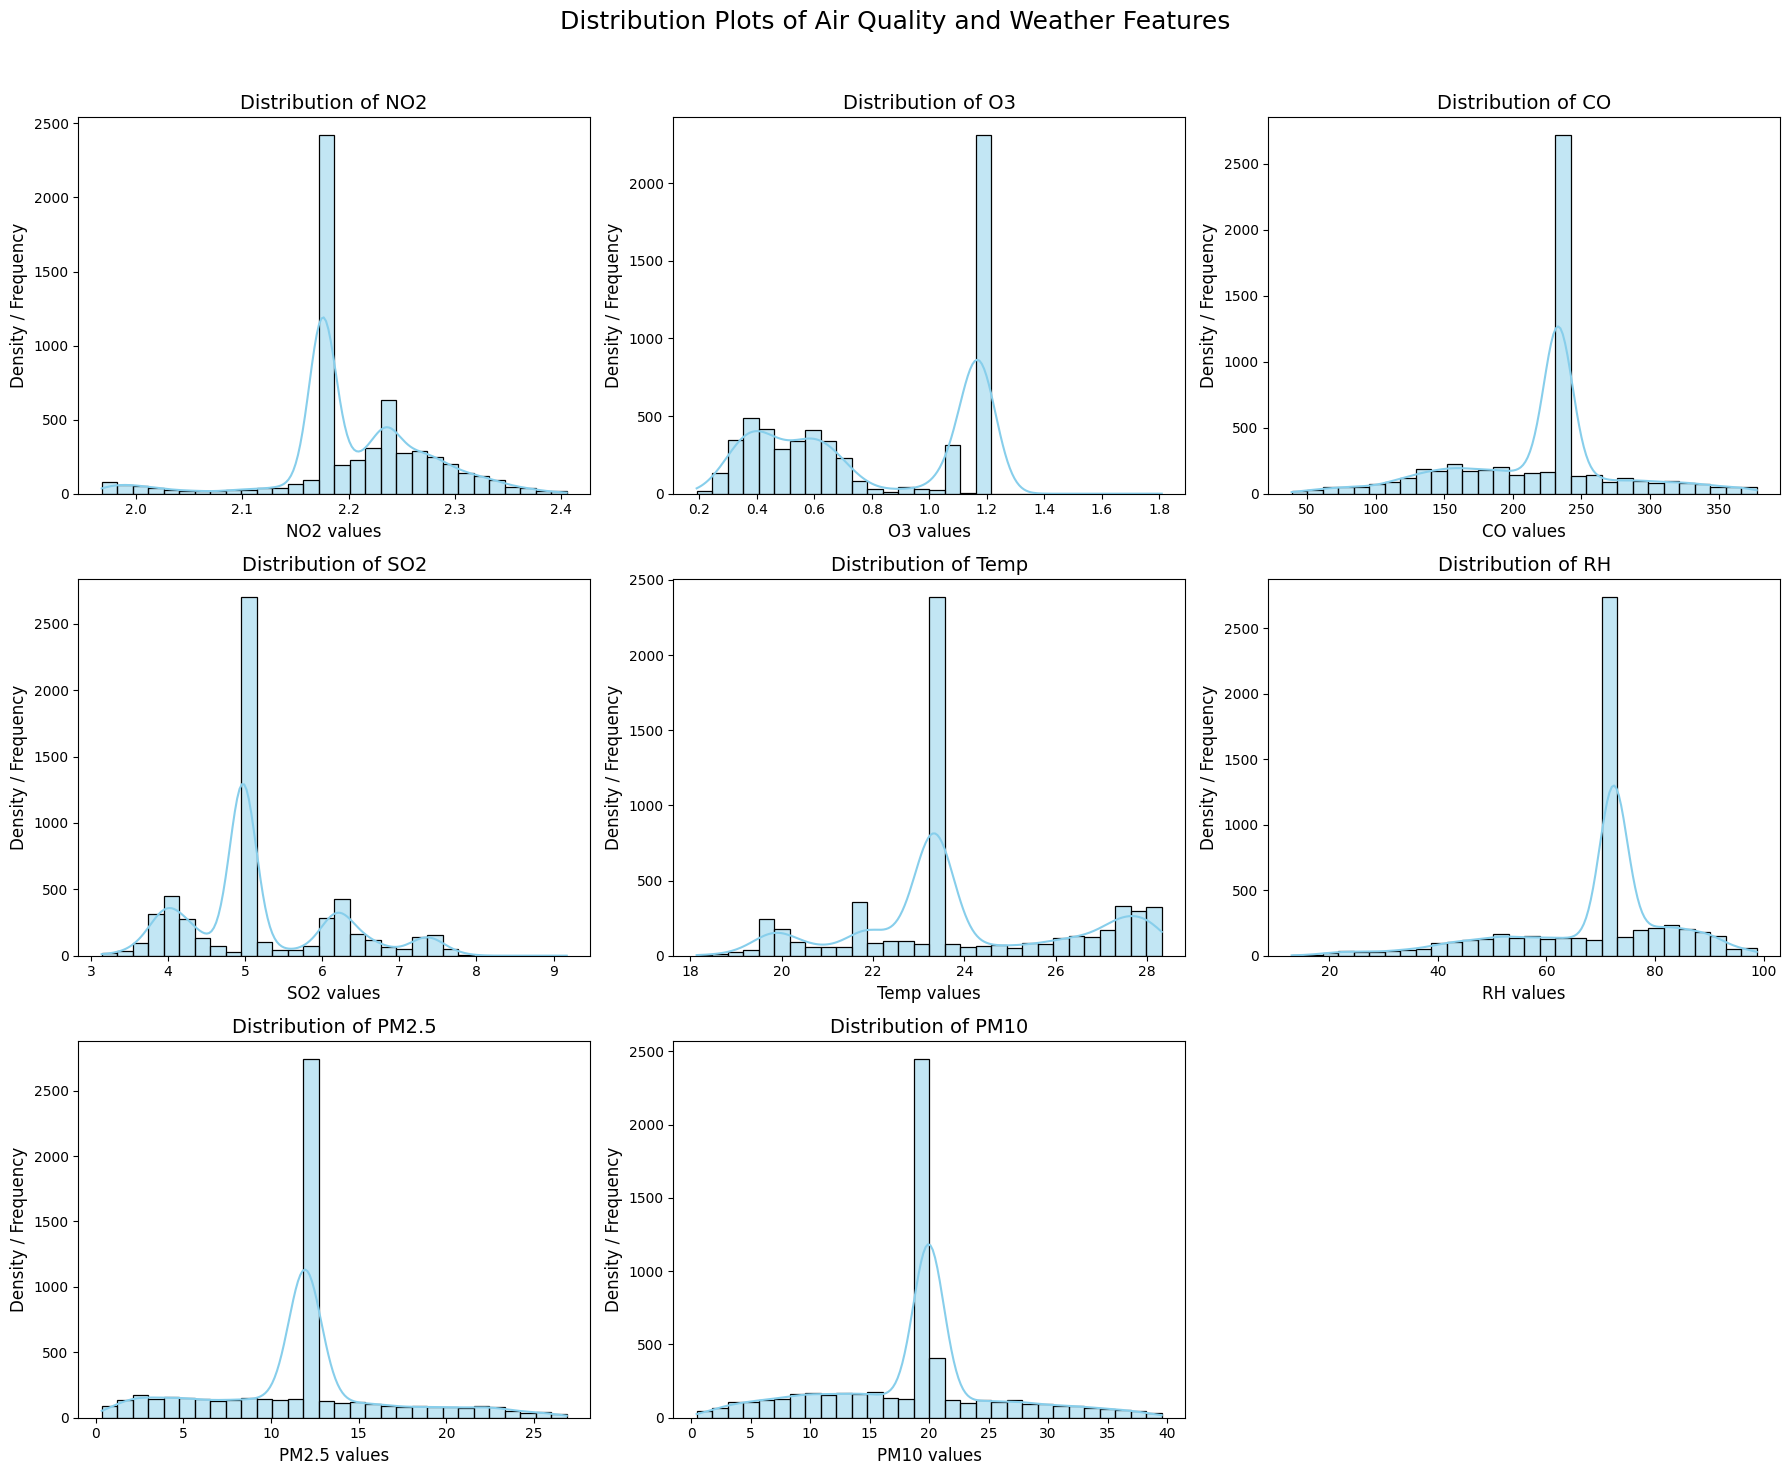

In [ ]:
columns = data.select_dtypes(include='number').columns
n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.histplot(data[col], kde=True, bins=30, ax=axes[i], edgecolor='black', color='skyblue')
    axes[i].set_title(f"Distribution of {col}", fontsize=14)
    axes[i].set_xlabel(f"{col} values", fontsize=12)
    axes[i].set_ylabel("Density / Frequency", fontsize=12)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution Plots of Air Quality and Weather Features", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


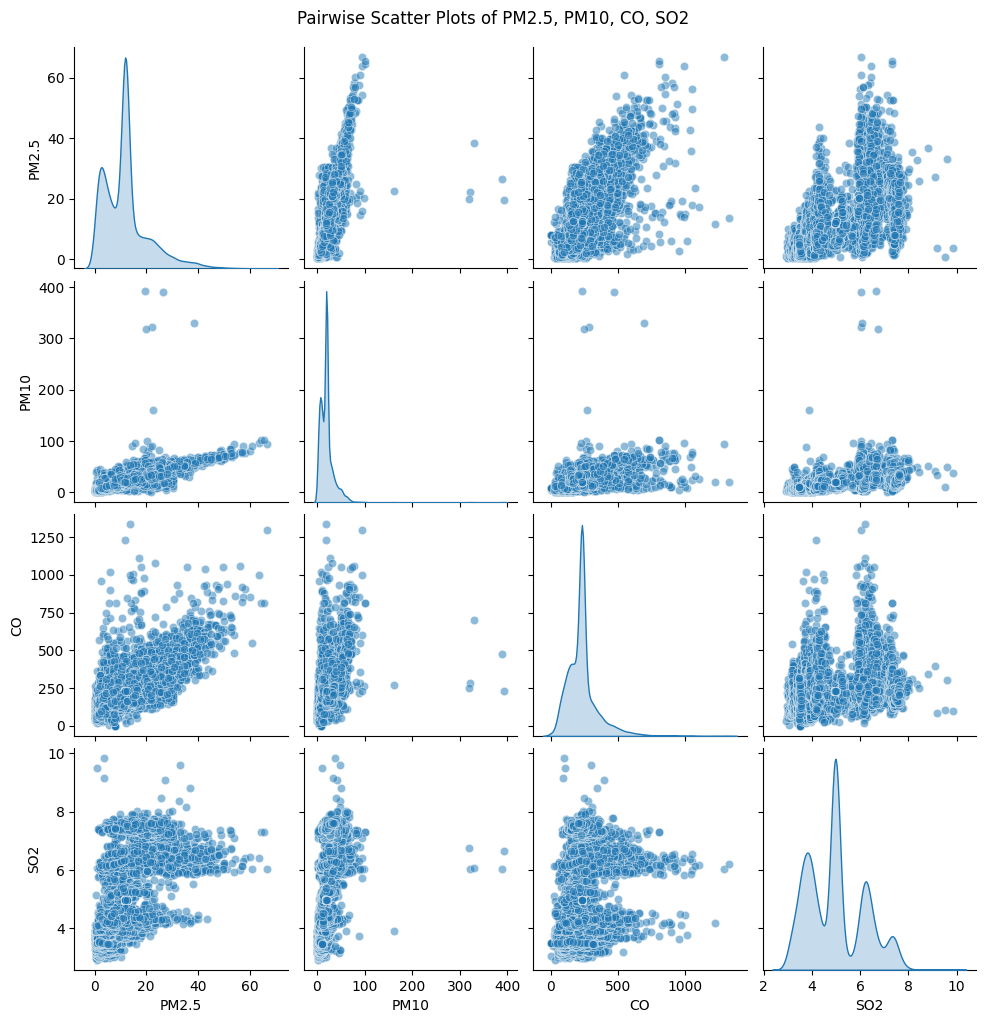

In [ ]:
features = ['PM2.5', 'PM10', 'CO', 'SO2']
data_selected = data[features]

sns.pairplot(data_selected, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle("Pairwise Scatter Plots of PM2.5, PM10, CO, SO2", y=1.02)
plt.show()
